In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import rcParams
from PIL import Image
%matplotlib inline

In [3]:
# importing relevant libraries
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms.baseline_only import BaselineOnly
from surprise.prediction_algorithms import SVD, SVDpp
from surprise.prediction_algorithms.slope_one import SlopeOne
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
import numpy as np

In [4]:
# Load movies
movies = pd.read_csv("./small_data/ml-latest-small//movies.csv")
#movies = movies.replace({np.nan: None}) # replace NaN with None
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
# Load movies
links = pd.read_csv("./data/links.csv")
links = links.replace({np.nan: None}) # replace NaN with None
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862
1,2,113497,8844
2,3,113228,15602
3,4,114885,31357
4,5,113041,11862


In [6]:
# Load movies
ratings = pd.read_csv("./data/ratings.csv")
#ratings = ratings.replace({np.nan: None}) # replace NaN with None
ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [7]:
# Load movies
tags = pd.read_csv("./data/tags.csv")
tags = tags.replace({np.nan: None}) # replace NaN with None
tags.head()

,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195


In [8]:
movies.count()

movieId    9742
title      9742
genres     9742
dtype: int64

In [9]:
links.count()

movieId    58098
imdbId     58098
tmdbId     57917
dtype: int64

In [10]:
ratings.count()

userId       27753444
movieId      27753444
rating       27753444
timestamp    27753444
dtype: int64

In [11]:
tags.count()

userId       1108997
movieId      1108997
tag          1108981
timestamp    1108997
dtype: int64

In [12]:
print("If there is missing data in each table?")
print('movie: {}'.format(movies.count() == movies.dropna().count()))
print('ratings: {}'.format(ratings.count() == ratings.dropna().count()))
print('links: {}'.format(links.count() == links.dropna().count()))
print('tags: {}'.format(tags.count() == tags.dropna().count()))

If there is missing data in each table?
movie: movieId    True
title      True
genres     True
dtype: bool
ratings: userId       True
movieId      True
rating       True
timestamp    True
dtype: bool
links: movieId    False
imdbId     False
tmdbId      True
dtype: bool
tags: userId       False
movieId      False
tag           True
timestamp    False
dtype: bool


In [13]:
#Using regular expressions to find a year stored between parentheses
#We specify the parantheses so we don't conflict with movies that have years in their titles
movies['year'] = movies.title.str.extract('(\(\d\d\d\d\))',expand=False)
#Removing the parentheses
movies['year'] = movies.year.str.extract('(\d\d\d\d)',expand=False)
#Removing the years from the 'title' column
movies['title'] = movies.title.str.replace('(\(\d\d\d\d\))', '')
#Applying the strip function to get rid of any ending whitespace characters that may have appeared
movies['title'] = movies['title'].apply(lambda x: x.strip())
movies.head(10)

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995
5,6,Heat,Action|Crime|Thriller,1995
6,7,Sabrina,Comedy|Romance,1995
7,8,Tom and Huck,Adventure|Children,1995
8,9,Sudden Death,Action,1995
9,10,GoldenEye,Action|Adventure|Thriller,1995


total of 951 unique genres from 9742 occurances.


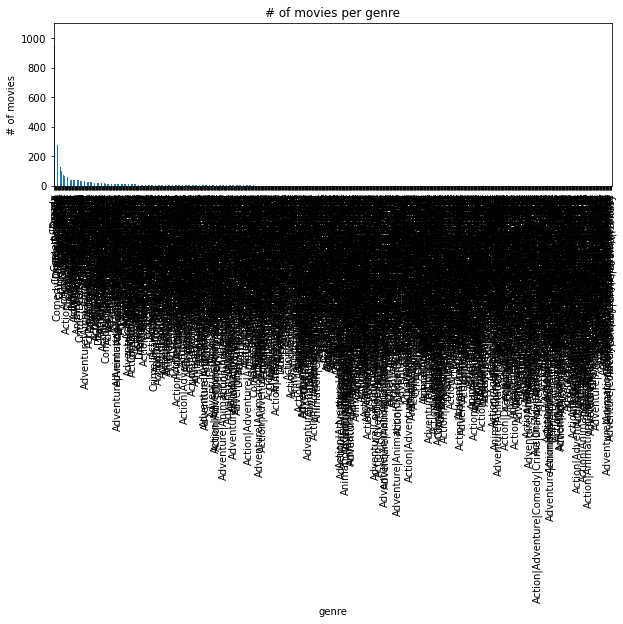

In [14]:
# Genres
all_genres = [s.split("| ") for s in movies[movies.genres.notnull()].genres]
genres = [item for l in all_genres for item in l ]
unique_genres = set(genres)
print (f"total of {len(unique_genres)} unique genres from {len(genres)} occurances.")
pd.Series(genres).value_counts().plot(kind='bar', figsize=(10, 3))
plt.title("# of movies per genre")
plt.ylabel("# of movies")
plt.xlabel("genre")
plt.show()

Total of 106 uinque years from 1902 to 2018


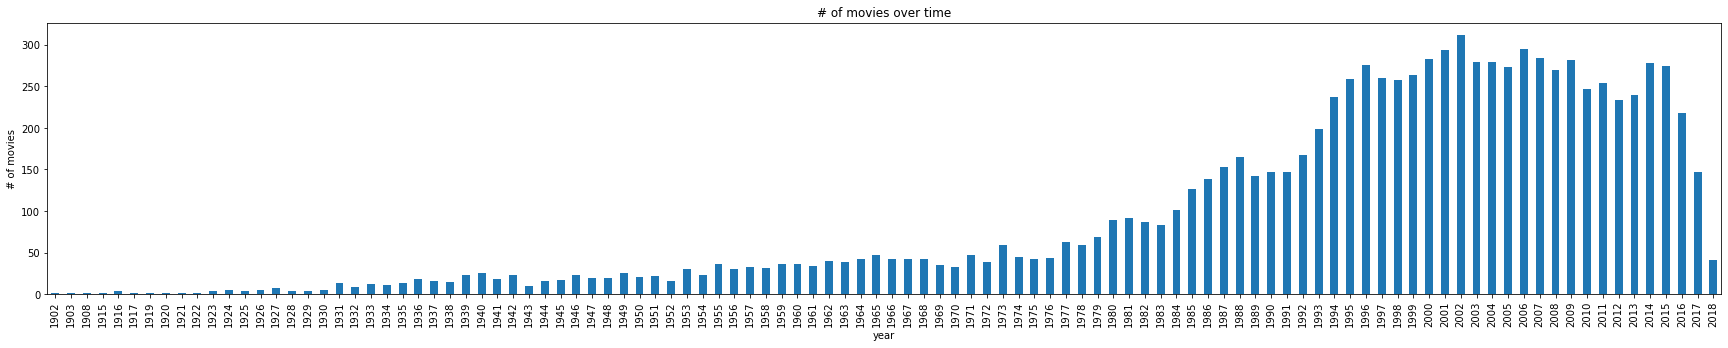

In [15]:
# Years
years = movies[movies.year.notnull()].year # get rows where year is not None
print (f"Total of {len(set(years))} uinque years from {min(years)} to {max(years)}")
pd.Series(years).value_counts().sort_index().plot(kind='bar', figsize=(30, 5))
plt.title("# of movies over time")
plt.ylabel("# of movies")
plt.xlabel("year")
plt.show()

In [16]:
#Every genre is separated by a | so we simply have to call the split function on |
movies['genres'] = movies.genres.str.split('|')
movies.head(10)

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995
5,6,Heat,"[Action, Crime, Thriller]",1995
6,7,Sabrina,"[Comedy, Romance]",1995
7,8,Tom and Huck,"[Adventure, Children]",1995
8,9,Sudden Death,[Action],1995
9,10,GoldenEye,"[Action, Adventure, Thriller]",1995


In [17]:
#Copying the movie dataframe into a new one since we won't need to use the genre information in our first case.
moviesWithGenres = movies.copy()

#For every row in the dataframe, iterate through the list of genres and place a 1 into the corresponding column
for index, row in movies.iterrows():
    for genre in row['genres']:
        moviesWithGenres.at[index, genre] = 1
#Filling in the NaN values with 0 to show that a movie doesn't have that column's genre
moviesWithGenres = moviesWithGenres.fillna(0)
moviesWithGenres.head(10)

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II,[Comedy],1995,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,Heat,"[Action, Crime, Thriller]",1995,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,Sabrina,"[Comedy, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,Tom and Huck,"[Adventure, Children]",1995,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,Sudden Death,[Action],1995,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,GoldenEye,"[Action, Adventure, Thriller]",1995,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
#Drop removes a specified row or column from a dataframe
ratings = ratings.drop('timestamp', 1)
ratings.head()

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


In [19]:
#Merge is a function that combines all the rows of the dataset with the specified dataframe.
data = ratings.merge(movies,on='movieId', how='left')
data.head(10)

,userId,movieId,rating,title,genres,year
0,1,307,3.5,Three Colors: Blue (Trois couleurs: Bleu),[Drama],1993
1,1,481,3.5,Kalifornia,"[Drama, Thriller]",1993
2,1,1091,1.5,Weekend at Bernie's,[Comedy],1989
3,1,1257,4.5,Better Off Dead...,"[Comedy, Romance]",1985
4,1,1449,4.5,Waiting for Guffman,[Comedy],1996
5,1,1590,2.5,Event Horizon,"[Horror, Sci-Fi, Thriller]",1997
6,1,1591,1.5,Spawn,"[Action, Adventure, Sci-Fi, Thriller]",1997
7,1,2134,4.5,Weird Science,"[Comedy, Fantasy, Sci-Fi]",1985
8,1,2478,4.0,¡Three Amigos!,"[Comedy, Western]",1986
9,1,2840,3.0,Stigmata,"[Drama, Thriller]",1999


# Content-Based Recommendation system

In [20]:
movies.head()

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


In [21]:
movie_profile = movies[['movieId', 'title', 'genres']]
movie_profile.rename(columns={'id': 'movieId'}, inplace=True)
genres = [item.strip() for l in all_genres for item in l ]
unique_genres = set(genres)
for genre in unique_genres:
  movie_profile[genre] = 0

C:\Users\nehcr\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [22]:
userInput = [
            {'title':'Fast & Furious (Fast and the Furious 4, The)', 'rating':4},
            {'title':'Jumanji: Welcome to the Jungle', 'rating':4.5},
            {'title':'Secret Superstar', 'rating':3},
            {'title':"Captain Marvel", 'rating':3.5},
            {'title':'Intern, The', 'rating':5}
         ] 
inputMovies = pd.DataFrame(userInput)
inputMovies

,title,rating
0,"Fast & Furious (Fast and the Furious 4, The)",4.0
1,Jumanji: Welcome to the Jungle,4.5
2,Secret Superstar,3.0
3,Captain Marvel,3.5
4,"Intern, The",5.0


In [23]:
#Filtering out the movies by title
inputId = movies[movies['title'].isin(inputMovies['title'].tolist())]
#Then merging it so we can get the movieId. It's implicitly merging it by title.
inputMovies = pd.merge(inputId, inputMovies)
#Dropping information we won't use from the input dataframe
inputMovies = inputMovies.drop('genres', 1).drop('year', 1)
#Final input dataframe
#If a movie you added in above isn't here, then it might not be in the original 
#dataframe or it might spelled differently, please check capitalisation.
inputMovies

,movieId,title,rating
0,67923,"Fast & Furious (Fast and the Furious 4, The)",4.0
1,179401,Jumanji: Welcome to the Jungle,4.5


In [24]:
#Filtering out the movies from the input
userMovies = moviesWithGenres[moviesWithGenres['movieId'].isin(inputMovies['movieId'].tolist())]
userMovies

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
7006,67923,"Fast & Furious (Fast and the Furious 4, The)","[Action, Crime, Drama, Thriller]",2009,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9636,179401,Jumanji: Welcome to the Jungle,"[Action, Adventure, Children]",2017,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
#Resetting the index to avoid future issues
userMovies = userMovies.reset_index(drop=True)
#Dropping unnecessary issues due to save memory and to avoid issues
userGenreTable = userMovies.drop('movieId', 1).drop('title', 1).drop('genres', 1).drop('year', 1)
userGenreTable

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
inputMovies['rating']

0    4.0
1    4.5
Name: rating, dtype: float64

In [27]:
#Dot produt to get weights
userProfile = userGenreTable.transpose().dot(inputMovies['rating'])
#The user profile
userProfile

Adventure             4.5
Animation             0.0
Children              4.5
Comedy                0.0
Fantasy               0.0
Romance               0.0
Drama                 4.0
Action                8.5
Crime                 4.0
Thriller              4.0
Horror                0.0
Mystery               0.0
Sci-Fi                0.0
War                   0.0
Musical               0.0
Documentary           0.0
IMAX                  0.0
Western               0.0
Film-Noir             0.0
(no genres listed)    0.0
dtype: float64

In [28]:
#Now let's get the genres of every movie in our original dataframe
genreTable = moviesWithGenres.set_index(moviesWithGenres['movieId'])
#And drop the unnecessary information
genreTable = genreTable.drop('movieId', 1).drop('title', 1).drop('genres', 1).drop('year', 1)
genreTable.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
movieId,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
genreTable.shape

(9742, 20)

In [30]:
#Multiply the genres by the weights and then take the weighted average
recommendationTable = ((genreTable*userProfile).sum(axis=1))/(userProfile.sum())
recommendationTable.head()

movieId
1    0.305085
2    0.305085
3    0.000000
4    0.135593
5    0.000000
dtype: float64

In [31]:
#Sort our recommendations in descending order
recommendationTable = recommendationTable.sort_values(ascending=False)
#Just a peek at the values
recommendationTable.head()

movieId
26504    0.864407
49530    0.847458
459      0.847458
6016     0.847458
81132    0.847458
dtype: float64

In [32]:
#The final recommendation table
movies.loc[movies['movieId'].isin(recommendationTable.head(20).keys())]

,movieId,title,genres,year
400,459,"Getaway, The","[Action, Adventure, Crime, Drama, Romance, Thr...",1994
1747,2344,Runaway Train,"[Action, Adventure, Drama, Thriller]",1985
1814,2414,Young Sherlock Holmes,"[Action, Adventure, Children, Fantasy, Mystery...",1985
1822,2422,"Karate Kid, Part III, The","[Action, Adventure, Children, Drama]",1989
1828,2429,Mighty Joe Young,"[Action, Adventure, Drama, Fantasy, Thriller]",1998
2623,3508,"Outlaw Josey Wales, The","[Action, Adventure, Drama, Thriller, Western]",1976
3085,4142,Left Behind: The Movie,"[Action, Adventure, Drama, Thriller]",2000
4176,6016,City of God (Cidade de Deus),"[Action, Adventure, Crime, Drama, Thriller]",2002
4409,6503,Charlie's Angels: Full Throttle,"[Action, Adventure, Comedy, Crime, Thriller]",2003
4859,7262,Catch That Kid,"[Action, Adventure, Children, Comedy, Crime]",2004


# Collaborative Filtering based Recommendation System

In [33]:
ratings_df = pd.read_csv('./small_data/ml-latest-small/ratings.csv')

In [34]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [35]:
ratings_df.shape

(100836, 4)

In [36]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [37]:
new_df = ratings_df.drop(columns='timestamp')

In [38]:
from surprise import Reader, Dataset
# read in values as Surprise dataset 

reader = Reader()
data = Dataset.load_from_df(new_df,reader)

In [39]:
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  610 

Number of items:  9724


### Collaborative Filtering Using SVD

In [45]:
## Perform a gridsearch with SVD
# ⏰ This cell may take several minutes to run
params = {'n_factors': [20, 50, 100],
         'reg_all': [0.02, 0.05, 0.1]}
g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1)
g_s_svd.fit(data)

In [46]:
# print out optimal parameters for SVD after GridSearch
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 0.8693697195305814, 'mae': 0.6681872327178962}
{'rmse': {'n_factors': 100, 'reg_all': 0.05}, 'mae': {'n_factors': 20, 'reg_all': 0.02}}


### Collaborative Filtering with SVD++

In [ ]:
# Perform a gridsearch with SVDpp
params = {'n_factors': [20, 50, 100],
         'reg_all': [0.02, 0.05, 0.1]}
g_s_svdpp = GridSearchCV(SVDpp,param_grid=params,n_jobs=-1)
g_s_svdpp.fit(data)

In [ ]:
# print out optimal parameters for SVD after GridSearch
print(g_s_svdpp.best_score)
print(g_s_svdpp.best_params)

### Collaborative Filtering Using Knn_basic

In [40]:
# cross validating with KNNBasic
knn_basic = KNNBasic(sim_options={'name':'pearson', 'user_based':True})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)

In [41]:
# print out the average RMSE score for the test set
for i in cv_knn_basic.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_basic['test_rmse']))

('test_rmse', array([0.9740238 , 0.97043971, 0.97222031, 0.97839729, 0.96106985]))
('test_mae', array([0.75225705, 0.7504283 , 0.75072529, 0.75555243, 0.7414922 ]))
('fit_time', (1.1754448413848877, 1.1284444332122803, 1.1333732604980469, 1.0933732986450195, 1.1446428298950195))
('test_time', (2.1287968158721924, 2.129199266433716, 2.188791036605835, 2.1377906799316406, 2.094796895980835))
-----------------------
0.9712301929448118


In [42]:
# cross validating with KNNBaseline
knn_baseline = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline,data)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [43]:
# print out the average score for the test set
for i in cv_knn_baseline.items():
    print(i)

np.mean(cv_knn_baseline['test_rmse'])

('test_rmse', array([0.87759632, 0.87047575, 0.88106869, 0.87293559, 0.88552438]))
('test_mae', array([0.66907351, 0.6666866 , 0.66947174, 0.66880897, 0.67797982]))
('fit_time', (1.9870777130126953, 2.0561721324920654, 1.8552677631378174, 1.8694772720336914, 1.9017739295959473))
('test_time', (5.060493230819702, 4.952100038528442, 4.697971820831299, 5.507988929748535, 4.566265821456909))


0.8775201467280714

In [44]:
### Collaborative Filtering Using Knn_basic

# cross validating with KNNBasic
knn_basic = KNNBasic(sim_options={'name':'pearson', 'user_based':True})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)

# print out the average RMSE score for the test set
for i in cv_knn_basic.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_basic['test_rmse']))

# cross validating with KNNBaseline
knn_baseline = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline,data)

# print out the average score for the test set
for i in cv_knn_baseline.items():
    print(i)

np.mean(cv_knn_baseline['test_rmse'])

('test_rmse', array([0.97092676, 0.96456048, 0.97019076, 0.97973375, 0.97938977]))
('test_mae', array([0.75147266, 0.74435603, 0.7493094 , 0.75887012, 0.75419714]))
('fit_time', (1.8690335750579834, 2.308769464492798, 2.230844259262085, 2.039701223373413, 2.0187480449676514))
('test_time', (4.914450407028198, 4.325583219528198, 4.98870849609375, 4.679365634918213, 4.80370831489563))
-----------------------
0.972960306427787
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
('test_rmse', array([0.87005962,

0.8770517678262291

### Reccs with SVD

In [ ]:
df_movies = pd.read_csv('./data/movies.csv')

In [ ]:
df_movies.head()

In [ ]:
svd = SVD(n_factors= 50, reg_all=0.05)
svd.fit(dataset)

In [ ]:
svd.predict(2, 4)

### User Ratings with SVD

In [ ]:
def movie_rater(movie_df,num, genre=None):
    userID = 1000
    rating_list = []
    while num > 0:
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list      

In [ ]:
user_rating = movie_rater(df_movies, 4, 'Comedy')

### New Users with SVD

In [ ]:
## add the new ratings to the original ratings DataFrame
new_ratings_df = new_df.append(user_rating,ignore_index=True)
new_data = Dataset.load_from_df(new_ratings_df,reader)

In [ ]:
# train a model using the new combined DataFrame
svd_ = SVD(n_factors= 50, reg_all=0.05)
svd_.fit(new_data.build_full_trainset())

In [ ]:
# make predictions for the user
# you'll probably want to create a list of tuples in the format (movie_id, predicted_score)
list_of_movies = []
for m_id in new_df['movieId'].unique():
    list_of_movies.append( (m_id,svd_.predict(1000,m_id)[3]))

In [ ]:
# order the predictions from highest to lowest rated
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)

In [ ]:
# return the top n recommendations using the 
def recommended_movies(user_ratings,movie_title_df,n):
        for idx, rec in enumerate(user_ratings):
            title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n-= 1
            if n == 0:
                break
            
recommended_movies(ranked_movies,df_movies,5)

# Test

In [ ]:
# https://www.programmersought.com/article/95994019232/

In [9]:
import sys
import numpy as np
import time
import random
import math
import os
from surprise.model_selection import KFold
from surprise import accuracy, KNNBasic, Reader
from collections import defaultdict
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import NMF, KNNBaseline


def get_top_n(predictions, n=10, threshold = 3.5):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n_est = defaultdict(list)
    true_ratings = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n_est[uid].append((iid, est))
        true_ratings[uid].append((iid, true_r))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n_est.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        user_ratings = [x for x in user_ratings if x[1] > threshold]
        top_n_est[uid] = user_ratings[:n]       # top n
        # add 0 if less than n
        est_len = len(top_n_est[uid])
        if est_len < n:
            for i in range(est_len, n):
                top_n_est[uid].append(('0', 0)) # append 0 if not enough
    # Then sort the true ratings for each user and retrieve the k highest ones.
    for uid, user_ratings in true_ratings.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        true_ratings[uid] = [x for x in user_ratings if x[1] > threshold]          # len

    return top_n_est, true_ratings


def nDCG(ranked_list, ground_truth):
    dcg = 0
    idcg = IDCG(len(ground_truth))
    for i in range(len(ranked_list)):
        id = ranked_list[i]
        if id not in ground_truth:
            continue
        rank = i + 1
        dcg += 1 / math.log(rank + 1, 2)
    return dcg / idcg if idcg != 0 else 0


def IDCG(n):
    idcg = 0
    for i in range(n):
        idcg += 1 / math.log(i + 2, 2)
    return idcg


def AP(ranked_list, ground_truth):
    hits, sum_precs = 0, 0.0
    for i in range(len(ranked_list)):
        id = ranked_list[i]
        if id in ground_truth:
            hits += 1
            sum_precs += hits / (i + 1.0)
    if hits > 0:
        return sum_precs / len(ground_truth)
    else:
        return 0.0


def RR(ranked_list, ground_list):
    for i in range(len(ranked_list)):
        id = ranked_list[i]
        if id in ground_list:
            return 1 / (i + 1.0)
    return 0


def precision_and_racall(ranked_list, ground_list):
    hits = 0
    for i in range(len(ranked_list)):
        id = ranked_list[i]
        if id in ground_list:
            hits += 1
    pre = hits / (1.0 * len(ranked_list) if len(ground_list) != 0 else 1)
    rec = hits / (1.0 * len(ground_list) if len(ground_list) != 0 else 1)
    return pre, rec


def evaluate(top_n_est, true_ratings):
    precision_list = []
    recall_list = []
    ap_list = []
    ndcg_list = []
    rr_list = []

    for u, user_ratings in top_n_est.items():
        tmp_r = top_n_est.get(u)  # [('302', 4.2889227920390836), ('258', 3.9492992642799027)]
        tmp_t = true_ratings.get(u)
        tmp_r_list = []
        tmp_t_list = []
        for (item, rate) in tmp_r:
            tmp_r_list.append(item)

        for (item, rate) in tmp_t:
            tmp_t_list.append(item)
        print(tmp_r_list, "-->", tmp_t_list)

        pre, rec = precision_and_racall(tmp_r_list, tmp_t_list)
        ap = AP(tmp_r_list, tmp_t_list)
        rr = RR(tmp_r_list, tmp_t_list)
        ndcg = nDCG(tmp_r_list, tmp_t_list)
        precision_list.append(pre)
        recall_list.append(rec)
        ap_list.append(ap)
        rr_list.append(rr)
        ndcg_list.append(ndcg)
    precison = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1 = 2 * precison * recall / (precison + recall)
    map = sum(ap_list) / len(ap_list)
    mrr = sum(rr_list) / len(rr_list)
    mndcg = sum(ndcg_list) / len(ndcg_list)
    return f1, map, mrr, mndcg


def evaluate_model_new(model, test_user, test_item, test_rate, top_n):
    recommend_dict = {}
    for u in test_user:
        recommend_dict[u] = {}
        for i in test_item:
            pred = model.predict(str(u), str(i), r_ui=4)
            est_str = '{est:1.4f}'.format(est=pred.est)
            recommend_dict[u][i] = float(est_str)

    precision_list = []
    recall_list = []
    ap_list = []
    ndcg_list = []
    rr_list = []

    for u in test_user:
        tmp_r = sorted(recommend_dict[u].items(), key = lambda x:x[1], reverse=True)[
                0:min(len(recommend_dict[u]), top_n)]
        tmp_t = sorted(test_rate[u].items(), key = lambda x:x[1], reverse=True)[
                0:min(len(test_rate[u]), len(test_rate[u]))]
        tmp_r_list = []
        tmp_t_list = []
        for (item, rate) in tmp_r:
            tmp_r_list.append(item)

        for (item, rate) in tmp_t:
            tmp_t_list.append(item)
        print(tmp_r_list, "-->", tmp_t_list)

        pre, rec = precision_and_racall(tmp_r_list, tmp_t_list)
        ap = AP(tmp_r_list, tmp_t_list)
        rr = RR(tmp_r_list, tmp_t_list)
        ndcg = nDCG(tmp_r_list, tmp_t_list)
        precision_list.append(pre)
        recall_list.append(rec)
        ap_list.append(ap)
        rr_list.append(rr)
        ndcg_list.append(ndcg)
    precison = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    # print(precison, recall)
    f1 = 2 * precison * recall / (precison + recall)
    map = sum(ap_list) / len(ap_list)
    mrr = sum(rr_list) / len(rr_list)
    mndcg = sum(ndcg_list) / len(ndcg_list)
    return f1, map, mrr, mndcg


def read_data(filename):
    users, items, rates = set(), set(), {}
    with open(filename, "r") as fin:
        line = fin.readline()
        while line:
            user, item, rate = line.strip().split()
            if rates.get(user) is None:
                rates[user] = {}
            rates[user][item] = float(rate)
            users.add(user)
            items.add(item)
            line = fin.readline()
    return users, items, rates


def main():
    rec = 'SVD'
    threshold = 4
    topK = 10
    # test_data_path = 'E:/Workspace/PyCharm/BiNE-master/data/1m/ratings_test.dat'
    # First train an SVD algorithm on the movielens dataset.
    print("load data...")
    # data = pd.read_csv('small_data/ml-latest-small/ratings.csv')
    # test set is made of 40% of the ratings.
    test_size = 0.4
    # trainset, testset = train_test_split(data, test_size=test_size)

    # path to dataset file
    # file_path = os.path.expanduser('E:/Workspace/PyCharm/BiNE-master/data/1m/ratings_train.dat')
    reader = Reader(line_format='user item rating', sep='\t')
    # data = Dataset.load_from_file(file_path, reader=reader)
    data = pd.read_csv('small_data/ml-latest-small/ratings.csv'')
    trainset = data.build_full_trainset()

    # test_user, test_item, test_rate = read_data(test_data_path)
    print("test size %.1f..." % test_size)
    print("training...")

    sim_options = {'name': 'cosine',

                   'user_based': False  # compute  similarities between items
                   }
    if rec == 'NMF':
        algo = NMF()
    elif rec == 'SVD':
        algo = SVD()
        name = ['SVD']
    else:
        algo = KNNBaseline(sim_options=sim_options)
        name = ['ItemKNN']

    train_start = time.time()
    algo.fit(trainset)
    train_end = time.time()
    print('train time:%.1f s' % (train_end - train_start))

    # Than predict ratings for all pairs (u, i) that are NOT in the training set.
    # testset = trainset.build_anti_testset()
    # predictions = algo.test(testset)
    test_end = time.time()
    print('test time:%.1f s' % (test_end - train_end))

    # top_n_est, true_ratings = get_top_n(predictions, n=10, threshold = threshold)

    f1, map, mrr, mndcg = evaluate_model_new(algo, test_user, test_item, test_rate, topK)
    eval_end = time.time()
    print('evaluate time:%.1f s' % (eval_end - test_end))
    print("algorithm : %s" % rec)
    print('recommendation metrics: F1 : %0.4f, NDCG : %0.4f, MAP : %0.4f, MRR : %0.4f' % (f1, mndcg, map, mrr))

    '''
    # Print the recommended items for each user
    for uid, user_ratings in top_n_est.items():
        print(uid, [iid for (iid, _) in user_ratings])
    print("#" * 150)
    for uid, user_ratings in top_n_true.items():
        print(uid, [iid for (iid, _) in user_ratings])
    '''



SyntaxError: EOL while scanning string literal (<ipython-input-9-8596da088210>, line 223)

In [10]:
main()

load data...


FileNotFoundError: [Errno 2] No such file or directory: 'E:/Workspace/PyCharm/BiNE-master/data/1m/ratings_train.dat'